In [64]:
import hashlib
import pandahouse
import swifter               
import scipy.stats as stats 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [66]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [67]:
query_users = """
SELECT DISTINCT user_id
FROM simulator_20250520.feed_actions
WHERE toDate(time) >= '2025-04-25'
  AND toDate(time) <= '2025-05-01'
"""

users_df = pandahouse.read_clickhouse(query_users, connection=connection)

In [68]:
users_df['hash_group'] = users_df['user_id'].swifter.apply(ab_split)

Pandas Apply:   0%|          | 0/41997 [00:00<?, ?it/s]

In [69]:
counts_by_group = users_df.groupby('hash_group')['user_id'].nunique().reset_index()
print("Число пользователей в каждой hash_group (0–4):")
print(counts_by_group)

Число пользователей в каждой hash_group (0–4):
   hash_group  user_id
0           0     8588
1           1     8254
2           2     8397
3           3     8305
4           4     8453


In [70]:
query_ctr = """
SELECT
    user_id,
    SUM(if(action = 'view', 1, 0))   AS views,
    SUM(if(action = 'like', 1, 0))  AS likes,
    CASE
        WHEN SUM(if(action = 'view', 1, 0)) = 0 THEN 0.0
        ELSE toFloat64(SUM(if(action = 'like', 1, 0))) 
             / toFloat64(SUM(if(action = 'view', 1, 0)))
    END AS ctr
FROM simulator_20250520.feed_actions
WHERE toDate(time) BETWEEN '2025-04-25' AND '2025-05-01'
GROUP BY user_id
"""

ctr_df = pandahouse.read_clickhouse(query_ctr, connection=connection)

In [71]:
ctr_df = ctr_df.set_index('user_id')

In [72]:
print("\nНесколько строк из ctr_df (user_id, views, likes, ctr):")
print(ctr_df.head())


Несколько строк из ctr_df (user_id, views, likes, ctr):
         views  likes       ctr
user_id                        
13289       32      2  0.062500
121096      57     12  0.210526
5090        14      2  0.142857
129283      80     23  0.287500
4394        54     25  0.462963


In [73]:
group2_ids_all = users_df.loc[users_df['hash_group'] == 2, 'user_id'].values
group3_ids_all = users_df.loc[users_df['hash_group'] == 3, 'user_id'].values
print(f"\nВсего в группе 2 пользователей: {len(group2_ids_all)}")
print(f"Всего в группе 3 пользователей: {len(group3_ids_all)}")


Всего в группе 2 пользователей: 8397
Всего в группе 3 пользователей: 8305


In [74]:
n_iterations = 10000
all_pvalues = []

In [75]:
for i in range(n_iterations):
    sampled_2 = np.random.choice(group2_ids_all, size=500, replace=False)
    sampled_3 = np.random.choice(group3_ids_all, size=500, replace=False)
    tmp2 = pd.DataFrame({'user_id': sampled_2})
    tmp3 = pd.DataFrame({'user_id': sampled_3})
    ctr_group2 = (tmp2.join(ctr_df[['ctr']], on='user_id', how='left').fillna(0.0)['ctr'])
    ctr_group3 = (tmp3.join(ctr_df[['ctr']], on='user_id', how='left').fillna(0.0)['ctr'])
    assert len(ctr_group2) == 500
    assert len(ctr_group3) == 500
    t_stat, p_val = stats.ttest_ind(ctr_group2, ctr_group3, equal_var=False)
    all_pvalues.append(p_val)

In [76]:
all_pvalues = np.array(all_pvalues)
share_below_005 = np.mean(all_pvalues < 0.05)
print(f"\nИз {n_iterations} A/A-тестов доля случаев, когда p-value < 0.05: {share_below_005:.4f}")


Из 10000 A/A-тестов доля случаев, когда p-value < 0.05: 0.0458


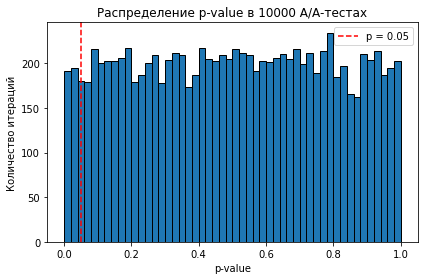

In [79]:
plt.figure(figsize=(6, 4))
plt.hist(all_pvalues, bins=50, edgecolor='k')
plt.axvline(0.05, color='red', linestyle='--', label='p = 0.05')
plt.title("Распределение p-value в 10000 A/A-тестах")
plt.xlabel("p-value")
plt.ylabel("Количество итераций")
plt.legend()
plt.tight_layout()
plt.show()